In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

import tempfile
from os import path
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Base MNIST model

In [18]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()



#### Constatns

In [19]:
# Model / data parameters
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)
MODEL_PATH = './mnist_models/first_mnist_model.h5'

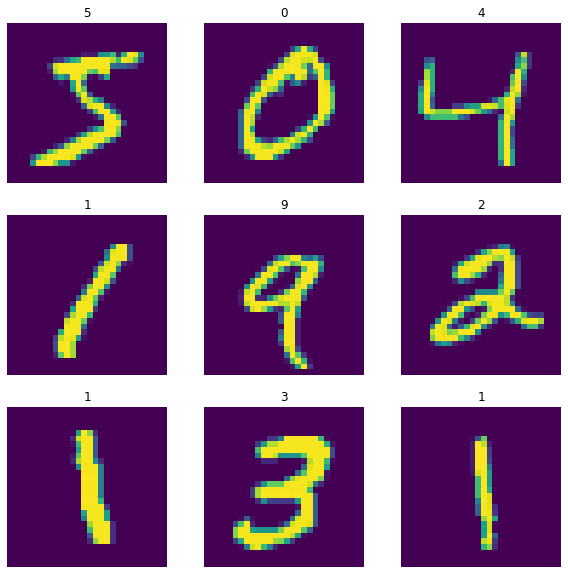

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i])
    plt.title(int(train_labels[i]))
    plt.axis("off")
    
plt.show()

In [21]:
tf.dtypes.cast(train_images, tf.float32)
tf.dtypes.cast(test_images, tf.float32)

<tf.Tensor: shape=(10000, 28, 28), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0

In [22]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(28, 1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)



In [23]:
if path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    
    # Compile
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
else:
    model = make_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

    # Train the digit classification model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.fit(
        train_images,
        train_labels,
        epochs=4,
        validation_split=0.1,
        batch_size=64,
    )
    
    # save model
    model.save(MODEL_PATH)
    print('Saved')
    

Epoch 1/4
844/844 [==============================] - 495s 584ms/step - loss: 0.2071 - accuracy: 0.9357 - val_loss: 0.1034 - val_accuracy: 0.9715
Epoch 2/4
844/844 [==============================] - 484s 573ms/step - loss: 0.0457 - accuracy: 0.9854 - val_loss: 0.0521 - val_accuracy: 0.9870
Epoch 3/4
844/844 [==============================] - 488s 578ms/step - loss: 0.0401 - accuracy: 0.9879 - val_loss: 0.0556 - val_accuracy: 0.9852
Epoch 4/4
844/844 [==============================] - 507s 601ms/step - loss: 0.0342 - accuracy: 0.9898 - val_loss: 0.0518 - val_accuracy: 0.9852
Saved


In [24]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 23s 75ms/step - loss: 0.0452 - accuracy: 0.9845


[0.04520625248551369, 0.984499990940094]

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 28, 28, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 28)   56          rescaling_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 28, 28, 28)   112         conv2d_6[0][0]                   
____________________________________________________________________________________________

# CIFAR  model

In [27]:
from tensorflow.keras import datasets

In [26]:
# Model / data parameters
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)
MODEL_PATH = './cifar_models/first_cifar_model.h5'

In [29]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2617s 15us/step


In [38]:
if path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    
    # Compile
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    print('Loaded from: ' + MODEL_PATH)
else:
    model = make_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

    # Train the digit classification model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    checkpoint_filepath = './tmp/'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    model.fit(
        train_images,
        train_labels,
        epochs=30,
        validation_split=0.1,
        batch_size=64,
        callbacks=[model_checkpoint_callback]
    )
    
    # save model
    model.save(MODEL_PATH)
    print('Saved to: ' + MODEL_PATH)
    

Epoch 1/30
704/704 [==============================] - 481s 675ms/step - loss: 1.5306 - accuracy: 0.4531 - val_loss: 0.9998 - val_accuracy: 0.6560
Epoch 2/30
704/704 [==============================] - 1773s 3s/step - loss: 0.8345 - accuracy: 0.7062 - val_loss: 0.9009 - val_accuracy: 0.7066
Epoch 3/30
704/704 [==============================] - 467s 663ms/step - loss: 0.6205 - accuracy: 0.7850 - val_loss: 0.7882 - val_accuracy: 0.7484
Epoch 4/30
704/704 [==============================] - 459s 651ms/step - loss: 0.4840 - accuracy: 0.8322 - val_loss: 0.7921 - val_accuracy: 0.7560
Epoch 5/30
704/704 [==============================] - 459s 652ms/step - loss: 0.3936 - accuracy: 0.8655 - val_loss: 0.9241 - val_accuracy: 0.7384
Epoch 6/30
704/704 [==============================] - 490s 697ms/step - loss: 0.3393 - accuracy: 0.8815 - val_loss: 0.8502 - val_accuracy: 0.7626
Epoch 7/30
704/704 [==============================] - 459s 652ms/step - loss: 0.2373 - accuracy: 0.9178 - val_loss: 0.8760 - v

In [36]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 32s 99ms/step - loss: 0.7219 - accuracy: 0.7756


[0.7163470983505249, 0.7759000062942505]